# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [1]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [ ]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
}
check_packages(d)

# Chapter 11 - Implementing a Multi-layer Artificial Neural Network from Scratch


### Overview

- [Modeling complex functions with artificial neural networks](#Modeling-complex-functions-with-artificial-neural-networks)
  - [Single-layer neural network recap](#Single-layer-neural-network-recap)
  - [Introducing the multi-layer neural network architecture](#Introducing-the-multi-layer-neural-network-architecture)
  - [Activating a neural network via forward propagation](#Activating-a-neural-network-via-forward-propagation)
- [Classifying handwritten digits](#Classifying-handwritten-digits)
  - [Obtaining the MNIST dataset](#Obtaining-the-MNIST-dataset)
  - [Implementing a multi-layer perceptron](#Implementing-a-multi-layer-perceptron)
  - [Coding the neural network training loop](#Coding-the-neural-network-training-loop)
  - [Evaluating the neural network performance](#Evaluating-the-neural-network-performance)
- [Training an artificial neural network](#Training-an-artificial-neural-network)
  - [Computing the loss function](#Computing-the-loss-function)
  - [Developing your intuition for backpropagation](#Developing-your-intuition-for-backpropagation)
  - [Training neural networks via backpropagation](#Training-neural-networks-via-backpropagation)
- [Convergence in neural networks](#Convergence-in-neural-networks)
- [Summary](#Summary)

<br>
<br>

In [7]:
from IPython.display import Image
%matplotlib inline

# Modeling complex functions with artificial neural networks

...

## Single-layer neural network recap

In [ ]:
Image(filename='figures/11_01.png', width=600) 

<br>
<br>

## Introducing the multi-layer neural network architecture

In [ ]:
Image(filename='figures/11_02.png', width=600) 

In [ ]:
Image(filename='figures/11_03.png', width=500) 

<br>
<br>

## Activating a neural network via forward propagation

<br>
<br>

# Classifying handwritten digits

...

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [1]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [2]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

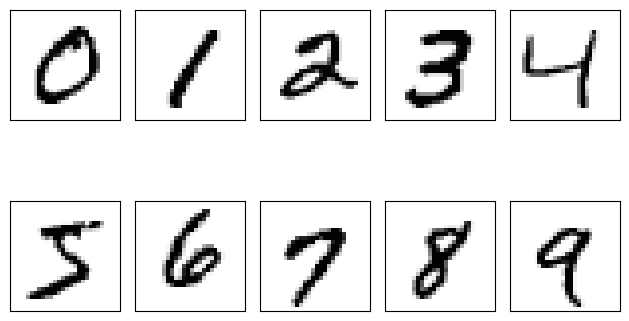

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

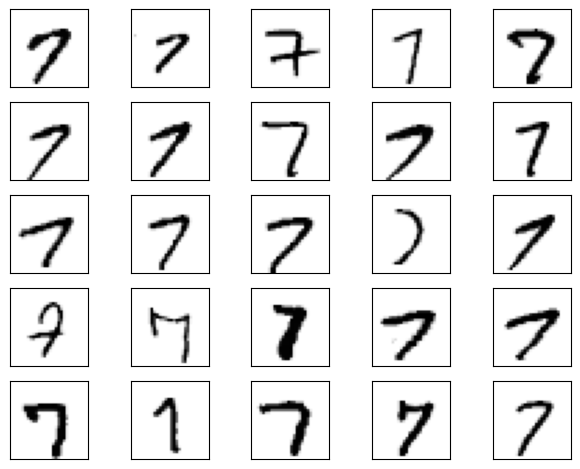

In [8]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [3]:
from sklearn.model_selection import train_test_split
from math import ceil

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=ceil(len(X)*0.3), random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=ceil(len(X_temp)*0.1), random_state=123, stratify=y_temp)




In [13]:
"""from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)"""


<br>
<br>

## Implementing a multi-layer perceptron

In [4]:
import numpy as np

In [5]:
##########################
### MODEL
##########################

def sigmoid(z):                                        
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In [6]:
##########################
### TWO LAYER MODEL - OUR IMPLEMENTATION
##########################


class NeuralNetMLP2L:

    def __init__(self, num_features, num_hidden_h1, num_hidden_h2, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)

        # hidden layer 1
        self.weight_h1 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden_h1, num_features))
        self.bias_h1 = np.zeros(num_hidden_h1)
        
        # hidden layer 2
        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden_h2, num_hidden_h1))
        self.bias_h2 = np.zeros(num_hidden_h2)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden_h2))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer 1
        # input dim: [n_examples, n_features] dot [n_hidden_h1, n_features].T
        # output dim: [n_examples, n_hidden_h1]
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Hidden layer 2
        # input dim: [n_examples, n_hidden_h1] dot [n_hidden_h2, n_hidden_h1].T
        # output dim: [n_examples, n_hidden_h2]
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)


        # Output layer
        # input dim: [n_examples, n_hidden_h2] dot [n_classes, n_hidden_h2].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h1, a_h2, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden_h2]
        d_z_out__dw_out = a_h2
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden_h2]
        # output dim: [n_classes, n_hidden_h2]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        #################################        
        # Part 2: dLoss/dHiddenWeights2
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden_h2]
        d_z_out__a_h2 = self.weight_out
        
        # output dim: [n_examples, n_hidden_h2]
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
        
        # [n_examples, n_hidden_h2]
        d_a_h__d_z_h2 = a_h2 * (1. - a_h2) # sigmoid derivative

        # Delta for hidden layer 2
        delta_h2 = d_loss__a_h2 * d_a_h__d_z_h2
        
        # [n_examples, n_hidden_h1]
        d_z_h__d_w_h2 = a_h1
        
        # output dim: [n_hidden, n_hidden_h1]
        d_loss__d_w_h2 = np.dot((d_loss__a_h2 * d_a_h__d_z_h2).T, d_z_h__d_w_h2)
        d_loss__d_b_h2 = np.sum((d_loss__a_h2 * d_a_h__d_z_h2), axis=0)
            

        #################################        
        # Part 3: dLoss/dHiddenWeights1
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h1 = self.weight_h2
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h1 = np.dot(delta_h2, d_z_out__a_h1)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h1 = a_h1 * (1. - a_h1) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h1 = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h1 = np.dot((d_loss__a_h1 * d_a_h__d_z_h1).T, d_z_h__d_w_h1)
        d_loss__d_b_h1 = np.sum((d_loss__a_h1 * d_a_h__d_z_h1), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h2, d_loss__d_b_h2,
                d_loss__d_w_h1, d_loss__d_b_h1)

## Coding the neural network training loop

Defining data loaders:

In [7]:
import torch
from torch.nn import MSELoss
from collections import OrderedDict
import torch.nn as nn
from torch.utils.data import DataLoader

In [8]:
num_epochs = 50
minibatch_size = 100
LR = 0.05


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

def minibatch_generator_PT(X, y, minibatch_size):
    indices = torch.arange(X.size(0))  # Create indices as a PyTorch tensor
    indices = indices[torch.randperm(indices.size(0))]  # Shuffle indices

    for start_idx in range(0, indices.size(0) - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

Defining a function to compute the loss and accuracy

In [9]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 

In [10]:
from sklearn.metrics import roc_auc_score

def compute_mse_acc_auc(nnet, X, y, num_labels=10, minibatch_size=minibatch_size):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    all_targets = []
    all_predictions = []
        
    for i, (features, targets) in enumerate(minibatch_gen):

        *_, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss
         # Collect for AUC computation
        all_targets.extend(onehot_targets)
        all_predictions.extend(int_to_onehot(predicted_labels, num_labels=num_labels))

    mse = mse/(i+1)
    auc = roc_auc_score(
        all_targets, all_predictions, multi_class='ovr', average='macro'
    )
    acc = correct_pred/num_examples
    return mse, acc, auc

In [32]:
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

def compute_mse_acc_auc_PT(nnet, X, y, num_labels=10, minibatch_size=minibatch_size):
    # Save the initial training state
    was_training = nnet.training
    
    # Set the model to evaluation mode
    nnet.eval()
    
    mse = 0
    correct_predictions = 0
    total_samples = 0
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        # Minibatch processing
        indices = torch.arange(X.size(0))
        indices = indices[torch.randperm(indices.size(0))]
        
        for start_idx in range(0, indices.size(0), minibatch_size):
            batch_idx = indices[start_idx:start_idx + minibatch_size]
            X_batch, y_batch = X[batch_idx], y[batch_idx]
            
            # Forward pass
            outputs = nnet(X_batch)
            
            # If y_batch is in class indices format, convert to one-hot encoding
            if y_batch.ndim == 1:
                y_batch_one_hot = F.one_hot(y_batch.type(torch.LongTensor), num_classes=num_labels).float()
            else:
                y_batch_one_hot = y_batch
            
            # Compute MSE
            mse += F.mse_loss(outputs, y_batch_one_hot, reduction='mean').item()
            
            # Predictions and accuracy
            predicted_classes = outputs.argmax(dim=1)
            true_classes = y_batch if y_batch.ndim == 1 else y_batch.argmax(dim=1)
            '''print(predicted_classes.reshape([predicted_classes.shape[0],1]).shape)
            print(true_classes.reshape([true_classes.shape[0],1]).shape)
            print(predicted_classes == true_classes)'''
            correct_predictions += (predicted_classes.cpu().detach().numpy().reshape([predicted_classes.shape[0],1]) == true_classes.cpu().detach().numpy().reshape([true_classes.shape[0],1])).sum()
            
            # Collect for AUC computation
            all_targets.extend(y_batch_one_hot.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())
            
            total_samples += X_batch.size(0)
    
    # Compute metrics
    mse /= (start_idx+1)
    acc = correct_predictions / total_samples
    macro_auc = roc_auc_score(
        all_targets, all_predictions, multi_class='ovr', average='macro'
    )
    
    # Restore the model's original training state
    if was_training:
        nnet.train()
    
    return mse, acc, macro_auc

In [12]:
from sklearn.metrics import roc_auc_score

def compute_mse_acc_auc_PT2(nnet, X, y, num_labels=10, minibatch_size=minibatch_size):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
        
    for i, (features, targets) in enumerate(minibatch_gen):

        with torch.no_grad():
            probas = nnet(torch.from_numpy(features).type(torch.FloatTensor))
        maxes, predicted_labels = torch.max(probas, dim=1)    
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = torch.mean((torch.from_numpy(onehot_targets) - probas)**2)
        correct_pred += (predicted_labels.numpy() == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss
    auc = roc_auc_score(y_true=onehot_targets, y_score=int_to_onehot(predicted_labels.numpy(), num_labels=num_labels), average='macro', multi_class='ovr')
    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc, auc

In [13]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=LR):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    epoch_train_auc = []
    epoch_valid_auc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc, train_auc = compute_mse_acc_auc(model, X_train, y_train)
        valid_mse, valid_acc, valid_auc = compute_mse_acc_auc(model, X_valid, y_valid)
        train_acc, valid_acc, train_auc, valid_auc = train_acc*100, valid_acc*100, train_auc*100, valid_auc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        epoch_train_auc.append(train_auc)
        epoch_valid_auc.append(valid_auc)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Train AUC: {train_auc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')
    
    return epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_train_auc, epoch_valid_auc

In [14]:
def train2L(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=LR):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    epoch_train_auc = []
    epoch_valid_auc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h2, d_loss__d_b_h2, d_loss__d_w_h1, d_loss__d_b_h1 = \
                model.backward(X_train_mini, a_h1, a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc, train_auc = compute_mse_acc_auc(model, X_train, y_train)
        valid_mse, valid_acc, valid_auc = compute_mse_acc_auc(model, X_valid, y_valid)
        train_acc, valid_acc, train_auc, valid_auc = train_acc*100, valid_acc*100, train_auc*100, valid_auc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        epoch_train_auc.append(train_auc)
        epoch_valid_auc.append(valid_auc)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Train AUC: {train_auc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_train_auc, epoch_valid_auc

In [20]:
def trainPT2(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=LR):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    epoch_train_auc = []
    epoch_valid_auc = []
    
    pt_mse = MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    print(optimizer)
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)
        

        for X_train_mini, y_train_mini in minibatch_gen:
            X_train_mini = torch.from_numpy(X_train_mini).type(torch.FloatTensor)
            y_train_mini = torch.nn.functional.one_hot(torch.from_numpy(y_train_mini).type(torch.LongTensor), num_classes=10).type(torch.FloatTensor)

            y_pred = model(X_train_mini)
            loss = pt_mse(y_pred, y_train_mini)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #### Epoch Logging ####        
        train_mse, train_acc, train_auc = compute_mse_acc_auc_PT2(model, X_train, y_train)
        valid_mse, valid_acc, valid_auc = compute_mse_acc_auc_PT2(model, X_valid, y_valid)
        train_acc, valid_acc, train_auc, valid_auc = train_acc*100, valid_acc*100, train_auc*100, valid_auc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        epoch_train_auc.append(train_auc)
        epoch_valid_auc.append(valid_auc)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Train AUC: {train_auc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_train_auc, epoch_valid_auc

In [35]:
def trainPT(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=LR):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    epoch_train_auc = []
    epoch_valid_auc = []
    
    critireon = MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    for e in range(num_epochs):
        
        # iterate over minibatches
        minibatch_gen = minibatch_generator_PT(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            y_train_mini = torch.nn.functional.one_hot(y_train_mini.type(torch.LongTensor), num_classes=10).type(torch.FloatTensor)
            y_pred = model(X_train_mini)
            loss = critireon(y_pred, y_train_mini)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        #### Epoch Logging ####        
        train_mse, train_acc, train_auc = compute_mse_acc_auc_PT(model, X_train, y_train)
        valid_mse, valid_acc, valid_auc = compute_mse_acc_auc_PT(model, X_valid, y_valid)
        train_acc, valid_acc, train_auc, valid_auc = train_acc*100, valid_acc*100, train_auc*100, valid_auc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        epoch_train_auc.append(train_auc)
        epoch_valid_auc.append(valid_auc)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Train AUC: {train_auc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_train_auc, epoch_valid_auc

In [37]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=50,
                     num_classes=10)

In [38]:
model2L = NeuralNetMLP2L(num_features=28*28,
                     num_hidden_h1=500,
                     num_hidden_h2=500,
                     num_classes=10)

In [39]:
PTmodel = nn.Sequential(
    nn.Linear(28 * 28, 500),  # First hidden layer
    nn.Sigmoid(),  # Activation function for the first hidden layer
    nn.Linear(500, 500),  # Second hidden layer
    nn.Sigmoid(),  # Activation function for the second hidden layer
    nn.Linear(500, 10),  # Output layer
    nn.Sigmoid()  # Activation function for the output layer
)

In [40]:
np.random.seed(123) # for the training set shuffling

epoch_loss1, epoch_train_acc1, epoch_valid_acc1, epoch_train_auc1, epoch_valid_auc1 = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=num_epochs, learning_rate=LR)

Epoch: 001/050 | Train MSE: 0.08 | Train Acc: 50.87% | Train AUC: 72.12% | Valid Acc: 51.18%
Epoch: 002/050 | Train MSE: 0.06 | Train Acc: 73.68% | Train AUC: 84.89% | Valid Acc: 73.80%
Epoch: 003/050 | Train MSE: 0.04 | Train Acc: 79.84% | Train AUC: 88.43% | Valid Acc: 79.73%
Epoch: 004/050 | Train MSE: 0.04 | Train Acc: 83.67% | Train AUC: 90.67% | Valid Acc: 83.06%
Epoch: 005/050 | Train MSE: 0.03 | Train Acc: 85.93% | Train AUC: 92.02% | Valid Acc: 85.65%
Epoch: 006/050 | Train MSE: 0.03 | Train Acc: 86.88% | Train AUC: 92.54% | Valid Acc: 86.16%
Epoch: 007/050 | Train MSE: 0.03 | Train Acc: 87.77% | Train AUC: 93.07% | Valid Acc: 87.53%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 88.27% | Train AUC: 93.35% | Valid Acc: 87.92%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 89.04% | Train AUC: 93.81% | Valid Acc: 88.88%
Epoch: 010/050 | Train MSE: 0.02 | Train Acc: 89.34% | Train AUC: 93.97% | Valid Acc: 89.08%
Epoch: 011/050 | Train MSE: 0.02 | Train Acc: 89.65% | Train AUC: 94.1

In [41]:
np.random.seed(123) # for the training set shuffling

epoch_loss2, epoch_train_acc2, epoch_valid_acc2, epoch_train_auc2, epoch_valid_auc2 = train2L(
    model2L, X_train, y_train, X_valid, y_valid,
    num_epochs=num_epochs, learning_rate=LR)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 75.22% | Train AUC: 85.79% | Valid Acc: 76.06%
Epoch: 002/050 | Train MSE: 0.04 | Train Acc: 83.86% | Train AUC: 90.84% | Valid Acc: 83.82%
Epoch: 003/050 | Train MSE: 0.03 | Train Acc: 85.99% | Train AUC: 92.04% | Valid Acc: 85.76%
Epoch: 004/050 | Train MSE: 0.03 | Train Acc: 87.66% | Train AUC: 93.02% | Valid Acc: 87.33%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 88.67% | Train AUC: 93.62% | Valid Acc: 88.84%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 89.22% | Train AUC: 93.92% | Valid Acc: 89.00%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 89.62% | Train AUC: 94.15% | Valid Acc: 89.59%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 89.92% | Train AUC: 94.31% | Valid Acc: 89.45%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 90.29% | Train AUC: 94.54% | Valid Acc: 90.20%
Epoch: 010/050 | Train MSE: 0.02 | Train Acc: 90.71% | Train AUC: 94.77% | Valid Acc: 90.27%
Epoch: 011/050 | Train MSE: 0.02 | Train Acc: 90.86% | Train AUC: 94.8

In [42]:
np.random.seed(123)
epoch_lossPT, epoch_train_accPT, epoch_valid_accPT, epoch_train_aucPT, epoch_valid_aucPT = trainPT(
    PTmodel, torch.from_numpy(X_train).type(torch.FloatTensor), torch.from_numpy(y_train).type(torch.FloatTensor), torch.from_numpy(X_valid).type(torch.FloatTensor), torch.from_numpy(y_valid).type(torch.FloatTensor),
    num_epochs=num_epochs, learning_rate=LR)

Epoch: 001/050 | Train MSE: 0.00 | Train Acc: 11.38% | Train AUC: 82.38% | Valid Acc: 11.35%
Epoch: 002/050 | Train MSE: 0.00 | Train Acc: 15.77% | Train AUC: 92.37% | Valid Acc: 15.55%
Epoch: 003/050 | Train MSE: 0.00 | Train Acc: 25.99% | Train AUC: 94.02% | Valid Acc: 26.61%
Epoch: 004/050 | Train MSE: 0.00 | Train Acc: 43.63% | Train AUC: 93.94% | Valid Acc: 43.37%
Epoch: 005/050 | Train MSE: 0.00 | Train Acc: 23.58% | Train AUC: 92.74% | Valid Acc: 23.57%
Epoch: 006/050 | Train MSE: 0.00 | Train Acc: 47.68% | Train AUC: 90.62% | Valid Acc: 47.82%
Epoch: 007/050 | Train MSE: 0.00 | Train Acc: 54.52% | Train AUC: 90.65% | Valid Acc: 55.20%
Epoch: 008/050 | Train MSE: 0.00 | Train Acc: 63.84% | Train AUC: 91.74% | Valid Acc: 64.35%
Epoch: 009/050 | Train MSE: 0.00 | Train Acc: 70.72% | Train AUC: 92.84% | Valid Acc: 71.20%
Epoch: 010/050 | Train MSE: 0.00 | Train Acc: 77.22% | Train AUC: 94.04% | Valid Acc: 77.43%
Epoch: 011/050 | Train MSE: 0.00 | Train Acc: 81.84% | Train AUC: 95.0

## Evaluating the neural network performance

In [48]:
import matplotlib.pyplot as plt

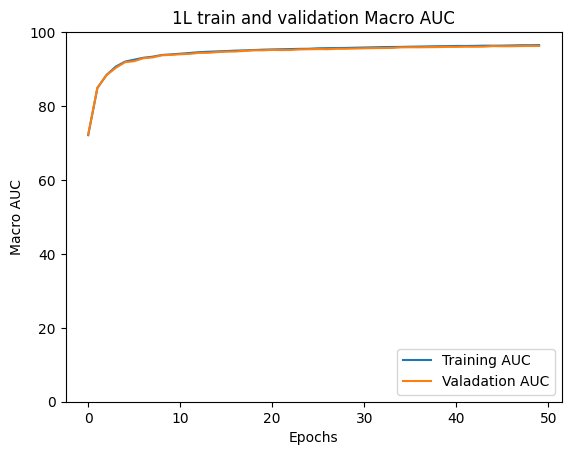

In [49]:
plt.plot(range(len(epoch_train_auc1)), epoch_train_auc1,
         label='Training AUC')
plt.plot(range(len(epoch_valid_auc1)), epoch_valid_auc1,
         label='Valadation AUC')
plt.ylabel('Macro AUC')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title("1L train and validation Macro AUC")
plt.ylim(0, 100)
plt.savefig('plots/1L_AUC.png', dpi=300)
plt.show()

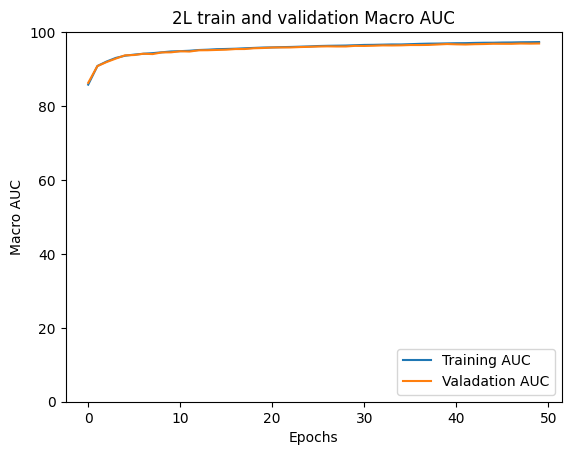

In [50]:
plt.plot(range(len(epoch_train_auc2)), epoch_train_auc2,
         label='Training AUC')
plt.plot(range(len(epoch_valid_auc2)), epoch_valid_auc2,
         label='Valadation AUC')
plt.ylabel('Macro AUC')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title("2L train and validation Macro AUC")
plt.ylim(0, 100)
plt.savefig('plots/2L_AUC.png', dpi=300)
plt.show()

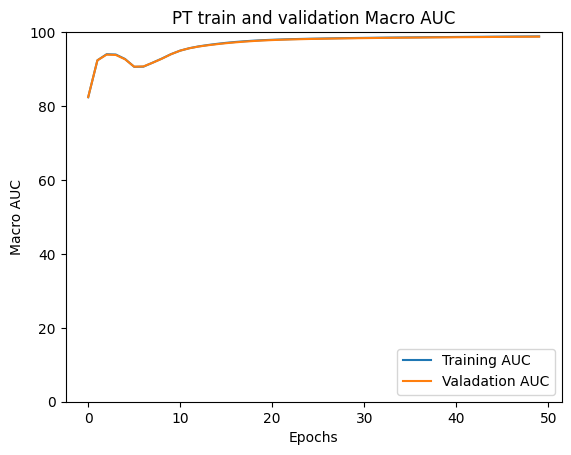

In [51]:
plt.plot(range(len(epoch_train_aucPT)), epoch_train_aucPT,
         label='Training AUC')
plt.plot(range(len(epoch_valid_aucPT)), epoch_valid_aucPT,
         label='Valadation AUC')
plt.ylabel('Macro AUC')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title("PT train and validation Macro AUC")
plt.ylim(0, 100)
plt.savefig('plots/PT_AUC.png', dpi=300)
plt.show()

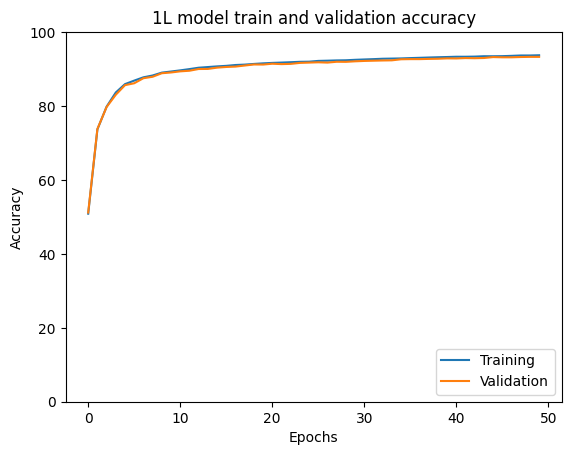

In [52]:
plt.plot(range(len(epoch_train_acc1)), epoch_train_acc1,
         label='Training')
plt.plot(range(len(epoch_valid_acc1)), epoch_valid_acc1,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title("1L model train and validation accuracy")
plt.ylim(0, 100)
plt.savefig('plots/1L_ACC.png', dpi=300)
plt.show()

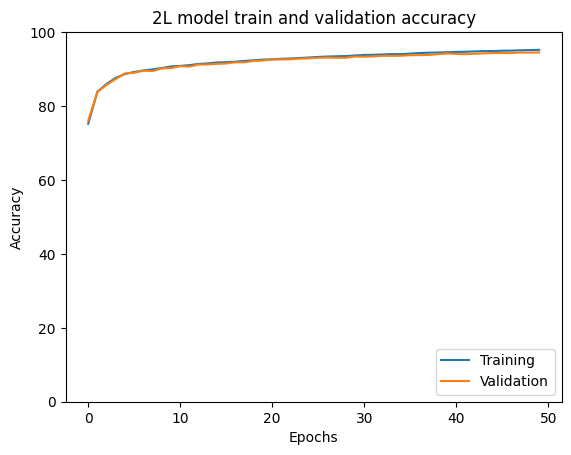

In [53]:
plt.plot(range(len(epoch_train_acc2)), epoch_train_acc2,
         label='Training')
plt.plot(range(len(epoch_valid_acc2)), epoch_valid_acc2,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title("2L model train and validation accuracy")
plt.ylim(0, 100)
plt.savefig('plots/2L_ACC.png', dpi=300)
plt.show()

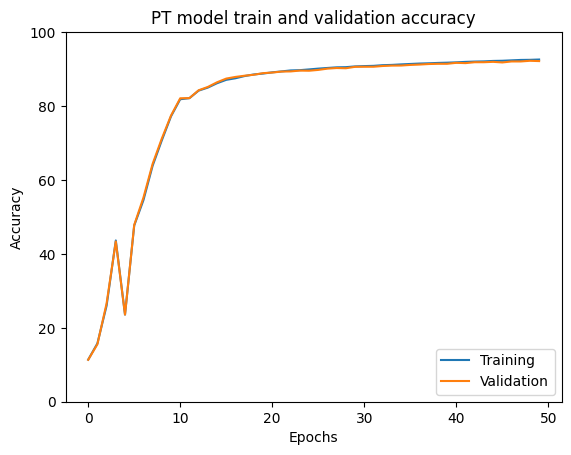

In [54]:
plt.plot(range(len(epoch_train_accPT)), epoch_train_accPT,
         label='Training')
plt.plot(range(len(epoch_valid_accPT)), epoch_valid_accPT,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title("PT model train and validation accuracy")
plt.ylim(0, 100)
plt.savefig('plots/PT_ACC.png', dpi=300)
plt.show()

In [55]:
test_mse, test_acc, test_auc = compute_mse_acc_auc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')
print(f'Test AUC: {test_auc*100:.2f}%')

Test accuracy: 93.13%
Test AUC: 96.14%


In [56]:
test_mse, test_acc, test_auc = compute_mse_acc_auc(model2L, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')
print(f'Test AUC: {test_auc*100:.2f}%')

Test accuracy: 94.60%
Test AUC: 96.97%


In [60]:
test_mse, test_acc, test_auc = compute_mse_acc_auc_PT(PTmodel, torch.from_numpy(X_test).type(torch.FloatTensor), torch.from_numpy(y_test).type(torch.FloatTensor))
print(f'Test accuracy: {test_acc*100:.2f}%')
print(f'Test AUC: {test_auc*100:.2f}%')

C:\Users\User\AppData\Local\Temp\ipykernel_16840\1209333346.py:1: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\python_arg_parser.cpp:315.)
  test_mse, test_acc, test_auc = compute_mse_acc_auc_PT(PTmodel, torch.from_numpy(X_test).type_as(torch.FloatTensor), torch.from_numpy(y_test).type_as(torch.FloatTensor))


TypeError: type_as(): argument 'other' (position 1) must be Tensor, not torch.tensortype

Plot failure cases:

In [ ]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

In [ ]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, _, probas = model2L.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

<br>
<br>

# Training an artificial neural network

...

## Computing the loss function

In [ ]:
Image(filename='figures/11_10.png', width=300) 

<br>
<br>

## Developing your intuition for backpropagation

...

## Training neural networks via backpropagation

In [ ]:
Image(filename='./figures/11_11.png', width=400) 

In [ ]:
Image(filename='figures/11_12.png', width=500) 

In [ ]:
Image(filename='figures/11_13.png', width=500) 

<br>
<br>

# Convergence in neural networks

In [ ]:
Image(filename='figures/11_14.png', width=500) 

<br>
<br>

...

# Summary

...

---

Readers may ignore the next cell.

In [ ]:
! python ../.convert_notebook_to_script.py --input ch11.ipynb --output ch11.py